In [1]:
import logging
import re
import sys
from os import listdir
from os.path import abspath, join

import geopandas as gpd
import geoplot as gplt
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from rasterio.features import shapes
from interviz.helpers.raster_to_polygons import disaggregate_viewsheds_and_convert_to_polygons

logging.basicConfig(stream=sys.stderr, level=logging.INFO)
logger = logging.getLogger('__name__')

% matplotlib inline

In [2]:
%pwd

'/home/joshainglis/other_projects/papers/isea_interviz'

## Read in shapefiles

In [3]:
import os
join(os.path.abspath(os.curdir), 'data', 'ISEA')

'/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA'

In [4]:
base_path = join(os.path.abspath(os.curdir), 'data', 'ISEA', 'Full_VS')

In [8]:
data_path = join(base_path, 'sl_-85')

In [40]:
def load_viewpoints(path: str, save_path: str=None) -> gpd.GeoDataFrame:
    viewpoints = gpd.read_file(path)
    viewpoints['FID'] = viewpoints.FID_split - 1
    if save_path is not None:
        viewpoints.to_file(save_path)
    return viewpoints[['FID', 'geometry']].set_index('FID', drop=False, verify_integrity=True)

def load_islands(path: str, save_path: str=None) -> gpd.GeoDataFrame:
    islands = gpd.read_file(path)
    islands['FID'] = islands.Id - 1
    islands = islands.set_index('FID', drop=False, verify_integrity=True)
    islands.geometry = islands.buffer(0)
    if save_path is not None:
        islands.to_file(save_path)
    return islands[['geometry']]

def load_split_islands(path: str, save_path: str=None) -> gpd.GeoDataFrame:
    split_islands = gpd.read_file(path)
    split_islands['FID_island'] = split_islands.Id - 1
    if save_path is not None:
        split_islands.to_file(save_path)
    return split_islands[['FID_island']]

In [41]:
viewpoints = load_viewpoints(join(data_path, 'gridded_viewpoints.shp'))
islands = load_islands(join(data_path, 'islands.shp'), join(data_path, 'islands_fixed.shp'))
split_islands = load_split_islands(join(data_path, 'split_islands.shp'), join(data_path, 'split_islands_fixed.shp'))

In [28]:
viewpoints.head()

,FID,geometry
FID,,
0,0,POINT Z (121.4899644644885 22.65515209079632 180)
1,1,POINT Z (119.2149264016322 22.45516143245419 -78)
2,2,POINT Z (119.0982577833702 22.3385002156125 -31)
3,3,POINT Z (118.7732523458192 22.3051684393721 -69)
4,4,POINT Z (121.5399653007581 22.05518011756851 436)


In [29]:
split_islands.head()

,FID_island
0,300
1,301
2,303
3,304
4,305


In [42]:
islands.head()

,geometry
FID,
0,"POLYGON ((130.8776215236162 30.17074027778, 13..."
1,"POLYGON ((131.135959179052 30.15407333226807, ..."
2,"POLYGON ((129.710935337776 30.13740638675597, ..."
3,"POLYGON ((126.4358805446681 30.1207394412441, ..."
4,"POLYGON ((126.502548326716 30.09573902297609, ..."


In [43]:
joined_viewpoints = viewpoints.join(split_islands, how='inner')
joined_viewpoints = joined_viewpoints[['FID_island', 'geometry']]
joined_viewpoints = joined_viewpoints.reset_index()
joined_viewpoints.columns = ['FID_point', 'FID_island', 'geometry']

In [44]:
joined_viewpoints.head()

,FID_point,FID_island,geometry
0,0,300,POINT Z (121.4899644644885 22.65515209079632 180)
1,1,301,POINT Z (119.2149264016322 22.45516143245419 -78)
2,2,303,POINT Z (119.0982577833702 22.3385002156125 -31)
3,3,304,POINT Z (118.7732523458192 22.3051684393721 -69)
4,4,305,POINT Z (121.5399653007581 22.05518011756851 436)


In [46]:
island_viewpoints = joined_viewpoints.join(islands, on='FID_island', rsuffix='_island')
# island_viewpoints.to_file(join(data_path, 'island_viewpoints.shp'))

In [47]:
island_viewpoints.head()

,FID_point,FID_island,geometry,geometry_island
0,0,300,POINT Z (121.4899644644885 22.65515209079632 180),"POLYGON ((121.5024646731162 22.62894743359999,..."
1,1,301,POINT Z (119.2149264016322 22.45516143245419 -78),"POLYGON ((119.227426610728 22.43727756021207, ..."
2,2,303,POINT Z (119.0982577833702 22.3385002156125 -31),"POLYGON ((119.0774241011201 22.27894157784812,..."
3,3,304,POINT Z (118.7732523458192 22.3051684393721 -69),"POLYGON ((118.8274199184401 22.25394115958011,..."
4,4,305,POINT Z (121.5399653007581 22.05518011756851 436),"POLYGON ((121.6024663461881 21.99560350414407,..."


### Validate that we've mapped the viewpoint ids to the island ids correctly

In [38]:
island_viewpoints.apply(lambda row: row['geometry_island'].contains(row['geometry']), axis=1).all()

True

### Quickly plot the data to ensure it looks correct

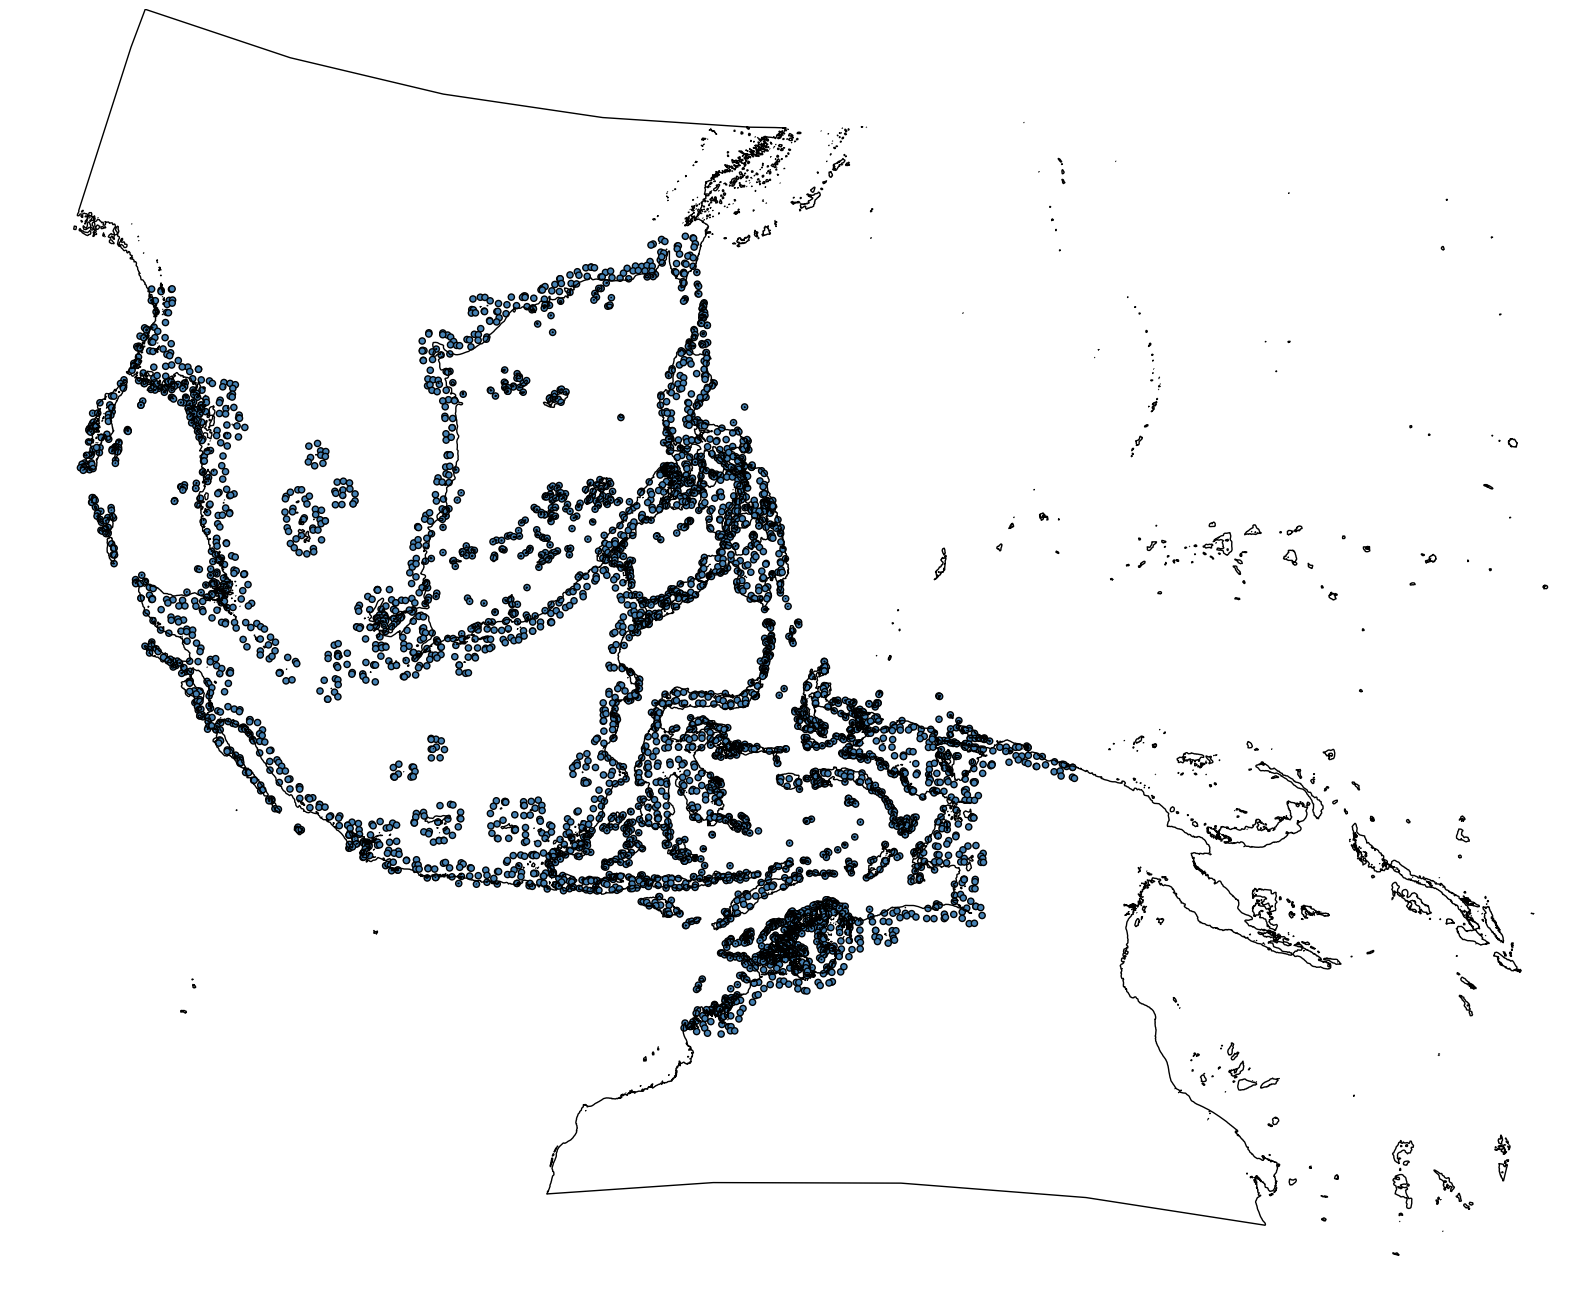

In [48]:
projection = gplt.crs.TransverseMercator()
ax = gplt.polyplot(islands, projection=projection, figsize=(20,20))
gplt.pointplot(island_viewpoints.geometry, ax=ax, projection=projection)
plt.show()

In [53]:
vs_re = re.compile(r'^viewshed_(\d{4})$')
folder = join(data_path, 'viewsheds/')
output_to = abspath(join(base_path, 'viewshed_polygons.shp'))

In [52]:
for viewshed_file in sorted(y for y in listdir(folder) if vs_re.match(y)):
    vs_num = int(vs_re.match(viewshed_file).group(1))
    raster_file = join(folder, viewshed_file)
    try:
        disaggregate_viewsheds_and_convert_to_polygons(raster_file, output_to, island_viewpoints, vs_num, use_windowing=False)
    except IndexError:
        continue

INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewshed_0001
INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewshed_0002
INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewshed_0003
INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewshed_0004
INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewshed_0005
INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewshed_0006
INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewsh

KeyboardInterrupt: 

In [54]:
poly_viewsheds = gpd.read_file(output_to)
poly_viewsheds['geometry'] = poly_viewsheds.buffer(0)
poly_viewsheds = poly_viewsheds.dissolve(by='FID_island')
poly_viewsheds['area'] = poly_viewsheds.geometry.area
poly_viewsheds_tmp = poly_viewsheds.geometry
poly_viewsheds_tmp.crs = {'init': 'epsg:4326'}
poly_viewsheds.geometry = poly_viewsheds_tmp.buffer(0)
poly_viewsheds = poly_viewsheds.reset_index()
poly_viewsheds.to_file(join(base_path, 'poly_viewsheds_dissolved.shp'))

In [9]:
poly_viewsheds = gpd.read_file(join(base_path, 'poly_viewsheds_dissolved.shp'))

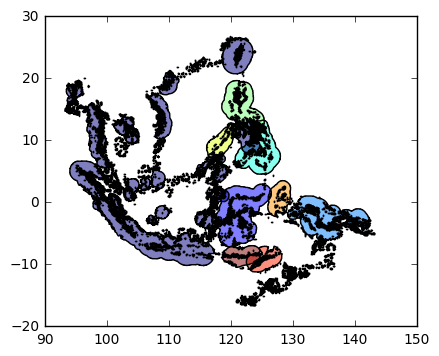

In [55]:
poly_viewsheds.sort_values(by='area', ascending=False).head(10).plot()

In [60]:
poly_viewsheds.reset_index().head()

,FID_island,geometry,FID_point,raster_val,area
0,300,"(POLYGON ((120.858813153646 22.059346589708, 1...",0,1,1.133089
1,301,"(POLYGON ((121.033804979095 23.467614137369, 1...",1,1,0.088186
2,303,"(POLYGON ((121.083802643509 23.634273018749, 1...",2,1,0.178386
3,304,"(POLYGON ((119.042231346604 22.384331408399, 1...",3,1,0.039996
4,305,"(POLYGON ((120.842147265508 22.70931622709, 12...",4,1,2.180699


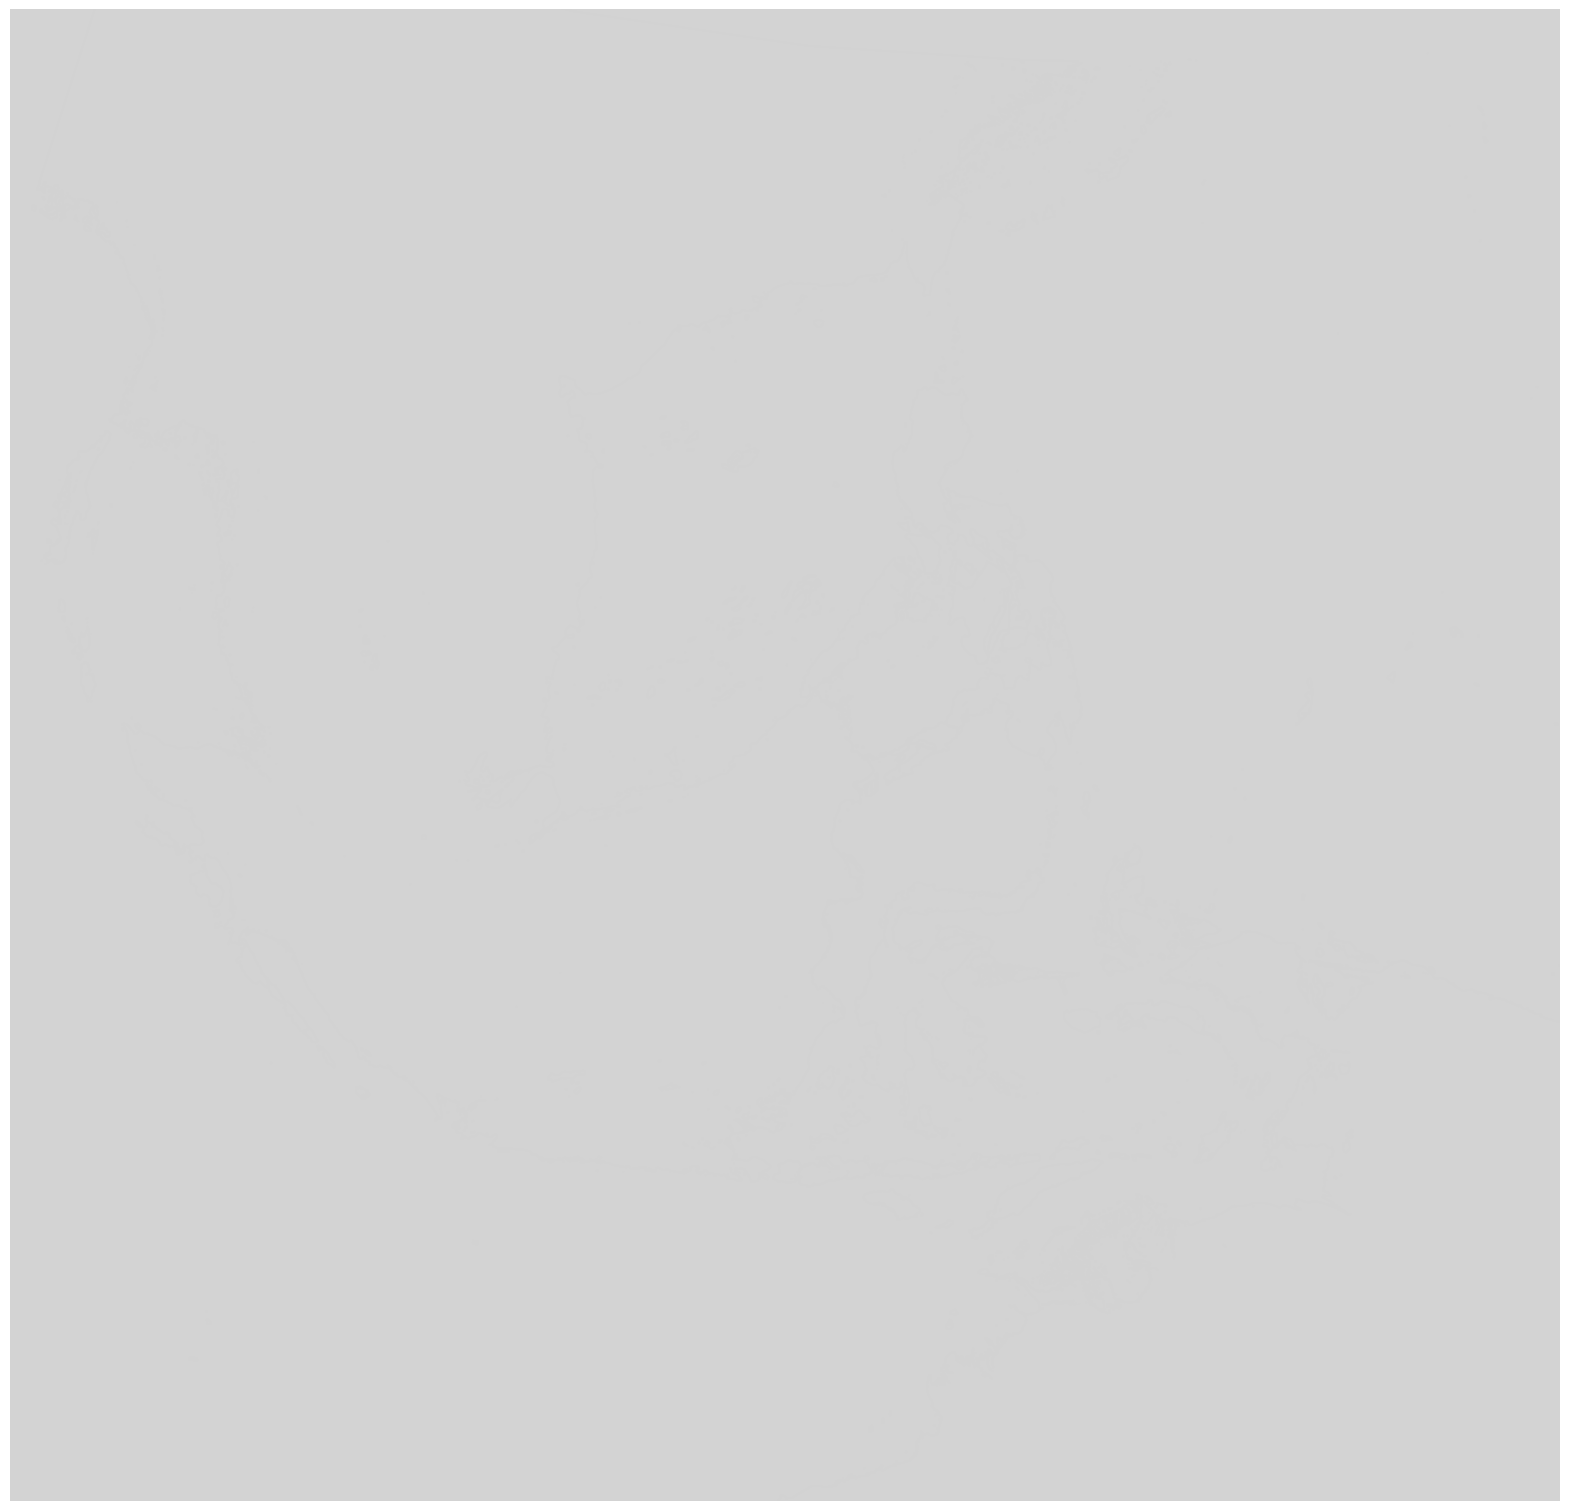

In [17]:
ax = gplt.polyplot(islands, projection=gplt.crs.TransverseMercator(), figsize=(12, 12))
gplt.polyplot(poly_viewsheds, projection=gplt.crs.TransverseMercator(), ax=ax, linewidth=0, facecolor='lightgray', alpha=0.5)
plt.show()

In [56]:
poly_viewsheds.shape

(1611, 4)

In [57]:
islands.shape

(2593, 1)

In [16]:
poly_viewsheds = gpd.read_file(join(base_path, 'poly_viewsheds_dissolved.shp'))
islands = gpd.read_file(join(data_path, 'islands_fixed.shp'))
r = gpd.sjoin(islands, poly_viewsheds, lsuffix='_islands', rsuffix='_viewsheds')
r.to_file('data/sl_-85/poly_viewsheds_joined.shp')

```bash
interviz-spatial-join data/sl_-85/islands_fixed.shp data/sl_-85/viewshed_polygons_chunked.shp data/sl_-85/poly_viewsheds_joined_2.shp
```

In [7]:
r = gpd.read_file(join(base_path, 'poly_viewsheds_joined.shp'))

In [10]:
poly_viewsheds.loc[1217].FID_point

2264

In [11]:
islands.loc[island_viewpoints.loc[2264].FID_island].geometry

NameError: name 'islands' is not defined

In [16]:
r.head(10)

,FID_point,Id,area,geometry,index_righ,raster_val
0,2264,199,0.000069,"POLYGON ((121.944138729184 26.29567544624001, ...",1217,1
1,2264,201,0.000069,"POLYGON ((121.8274701106 26.28734197348405, 12...",1217,1
2,2264,204,0.000069,"POLYGON ((121.677467600992 26.26234155521598, ...",1217,1
3,2264,206,0.000069,"POLYGON ((122.4524805673 26.24567460970411, 12...",1217,1
4,2264,207,0.000069,"POLYGON ((122.1441420753281 26.23734113694798,...",1217,1
5,2264,208,0.000069,"POLYGON ((122.7358186410042 26.22900766419201,...",1217,1
6,2264,210,0.000069,"POLYGON ((121.652467182724 26.204007245924, 12...",1217,1
7,2264,213,0.000069,"POLYGON ((122.0441404022563 26.16233988214407,...",1217,1
8,2264,214,0.000069,"POLYGON ((122.0441404022563 26.10400557285209,...",1217,1
9,2264,219,0.000069,"POLYGON ((121.7691358013082 26.01233737253608,...",1217,1


In [17]:
r['idx_island'] = r.Id - 1
r['idx_viewshed'] = r.index_righ
r_unique = r[r.idx_island != r.idx_viewshed]
r_unique = r_unique.reset_index().set_index(['idx_viewshed', 'idx_island'])
x = list({row[0] for i, row in r_unique.reset_index().iterrows()})

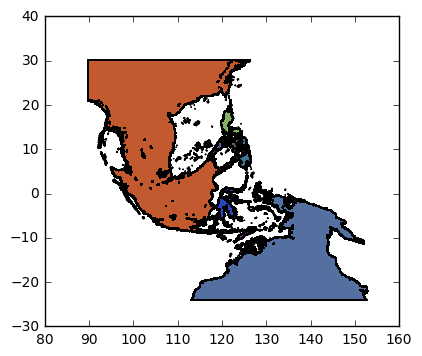

In [26]:
r_unique.plot()

In [18]:
islands.geometry = islands.buffer(0)
poly_viewsheds.geometry = poly_viewsheds.buffer(0)

G = nx.DiGraph()
for idx, (i, row) in enumerate(r_unique.reset_index().iterrows()):
    if i % 500 == 0:
        print(i)
    intersect = poly_viewsheds.loc[row['idx_viewshed']].geometry.intersection(islands.loc[row['idx_island']].geometry)
    G.add_edge(row['idx_viewshed'], row['idx_island'], area=intersect.area, region=intersect)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500


In [19]:
GG = nx.DiGraph()
for node_a, node_b in G.edges_iter():
    if node_a in G.edge[node_b]:
        GG.add_edge((node_a, node_b), (node_b, node_a))
        cab = G.edge[node_a][node_b]['region'].centroid
        GG.node[(node_a, node_b)]['coord'] = (cab.x, cab.y)

In [27]:
GG = nx.DiGraph()
for node_a, node_b in G.edges_iter():
    GG.add_edge((node_a, node_b), (node_b, node_a))
    cab = G.edge[node_a][node_b]['region'].centroid
    GG.node[(node_a, node_b)]['coord'] = (cab.x, cab.y)

In [20]:
pos = {node: GG.node[node]['coord'] for node in GG.nodes_iter()}

In [21]:
G.size()

12891

In [22]:
GG.size()

2

In [18]:
g = gpd.GeoDataFrame([
    {
        'idx_a': node_a,
        'idx_b': node_b,
        'geometry': G[node_a][node_b]['region']
    } for node_a, node_b in GG.nodes_iter()
], geometry='geometry', crs=islands.crs)

In [70]:
g.crs

{'init': 'epsg:4326'}

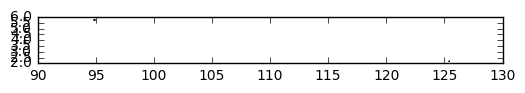

In [20]:
g.plot()

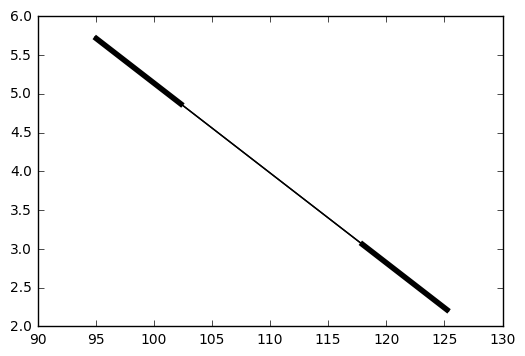

In [19]:
nx.draw_networkx_edges(GG, pos=pos)

In [24]:
rr = r_unique[['index_right']]

In [72]:
r_unique['geometry'] = r_unique.apply(lambda row: G[row.name[0]][row.name[1]]['region'], axis=1)

ValueError: Shape of passed values is (14782, 4), indices imply (14782, 5)

In [87]:
r_unique = r_unique[['geometry']].apply(lambda row: (G[row.name[0]][row.name[1]]['region'],), axis=1)

In [39]:
rr = gpd.GeoDataFrame(rr)

In [27]:
islands.head()

,Id,geometry,FID
FID,,,
0,1,"POLYGON ((125.742735898502 -8.060893901034945,...",0
1,2,"POLYGON ((129.767735898502 -8.06589390103494, ...",1
2,3,POLYGON ((127.2102358985022 -8.110893901035013...,2
3,4,POLYGON ((122.1327358985021 -8.125893901034999...,3
4,5,POLYGON ((124.6202358985021 -8.125893901034999...,4


,FID_island,Z,geometry
FID,,,
0,0,161,POINT Z (125.7439858986305 -8.024643901794548 ...
1,1,289,POINT Z (129.7289858985805 -8.024643901794548 ...
2,2,227,POINT Z (127.1739858988302 -8.044643901394863 ...
3,2,87,POINT Z (127.2189858983807 -8.094643901294887 87)
4,3,166,POINT Z (122.1314858986553 -8.112143901619731 ...


In [34]:
r_unique.head()

,FID_point,Id,area,geometry,gridcode,index_righ,raster_val,FID_island,idx_island,idx_viewshed
0,48,1,0.004888,"POLYGON ((125.742735898502 -8.060893901034945,...",1,32,1,0,0,32
1,48,3,0.004888,POLYGON ((127.2102358985022 -8.110893901035013...,1,32,1,2,2,32
2,48,5,0.004888,POLYGON ((124.6202358985021 -8.125893901034999...,1,32,1,4,4,32
4,48,60,0.004888,"POLYGON ((124.105235898502 -8.558393901034947,...",1,32,1,59,59,32
5,48,190,0.004888,"POLYGON ((123.612735898502 -10.04839390103501,...",1,32,1,189,189,32


In [28]:
for node in G.nodes_iter():
    c = r_unique.loc[node].geometry.centroid
    G.node[node]['coord'] = (c.x, c.y)
for node_a, node_b in G.edges_iter()
    

14783

In [29]:
pos = {node: G.node[node]['coord'] for node in G.nodes_iter()}

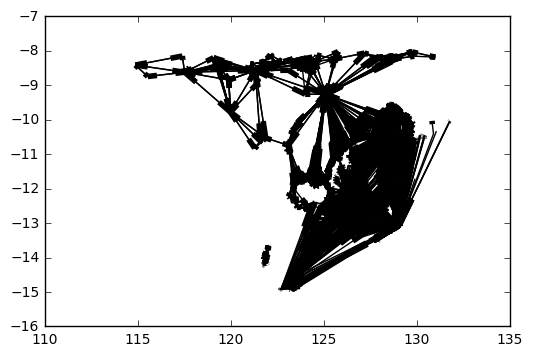

In [30]:
nx.draw_networkx_edges(G, pos=pos)

In [56]:
s, e = zip(*GG.edges_iter())
s = np.array(s)
e = np.array(e)
# gplt.sankey(start=islands.loc[s], end=islands.loc[e])

In [57]:
f, b = list(zip(e, s)), list(zip(s, e))

In [113]:
r_unique.centroid.loc[f]

index_right  index
32           0        POINT (125.7619072651938 -8.022816351954997)
59           0        POINT (125.7437447424986 -8.026258964776773)
189          0        POINT (125.7620756162693 -8.022250676757272)
28           1         POINT (129.705268013874 -8.034145361492842)
20           1        POINT (129.7069350769084 -8.024682371173208)
22           1        POINT (129.7535708858672 -8.034398594062623)
44           1        POINT (129.7326622230713 -8.009504619641815)
32           2        POINT (127.1638192318353 -8.050810567701655)
27           2        POINT (127.2007357728182 -8.065294618916621)
189          2        POINT (127.1777511213766 -8.073738078957851)
30           2        POINT (127.2054734983399 -8.064794202273804)
48           3        POINT (122.1242001462127 -8.119616734637741)
50           3        POINT (122.1238556373413 -8.118585065115621)
37           3        POINT (122.1239676015535 -8.119975577942023)
38           3        POINT (122.1220246318

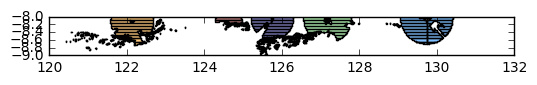

In [59]:
poly_viewsheds.head().plot()

In [91]:
gg = g.set_index(['idx_a', 'idx_b']).buffer(0)

In [129]:
gg[gg.apply(lambda x: not x.is_empty and x.area > 1e-9)].area.sort_values(ascending=True)

idx_a  idx_b
1171   1189     1.001365e-08
1172   1189     1.001365e-08
1177   1189     1.001365e-08
1176   1189     1.001365e-08
1133   1129     1.279145e-08
102    114      2.694553e-08
421    456      2.695312e-08
543    601      2.695312e-08
430    455      2.695312e-08
587    645      2.695312e-08
589    645      2.695312e-08
337    288      5.226279e-08
1237   1244     1.624429e-07
1238   1244     1.624429e-07
1232   1241     1.624429e-07
166    173      1.625102e-07
598    578      1.625776e-07
722    724      1.625776e-07
521    523      1.625776e-07
957    976      1.625776e-07
956    976      1.625776e-07
1025   1016     1.662098e-07
602    583      1.668731e-07
639    625      1.668731e-07
574    627      1.876951e-07
1025   1019     1.876951e-07
533    560      1.876951e-07
537    591      1.895307e-07
181    57       1.916952e-07
67     45       1.916952e-07
                    ...     
54     66       6.206622e-02
47     189      6.290000e-02
54     67       7.048119e-02
4

In [199]:
x = gg[gg.apply(lambda x: not x.is_empty and x.area > 1e-9)]
xa = gpd.GeoDataFrame(x.centroid, geometry=0, crs=islands.crs)
xa.columns = ['geometry']
xa_tmp = xa.reset_index()
xa_tmp['idx'] = xa_tmp.apply(lambda y: (y.idx_a, y.idx_b), axis=1)
xa_tmp['idx_other'] = xa_tmp.apply(lambda y: (y.idx_b, y.idx_a), axis=1)
xa_tmp = xa_tmp.set_index('idx')
paths = xa_tmp.join(xa_tmp, on='idx_other', lsuffix='_ab', rsuffix='_ba')
paths = paths[paths.apply(lambda y: y.geometry_ab is not np.nan and y.geometry_ba is not np.nan, axis=1)]

In [207]:
x[x.area == x.area.max()]

idx_a  idx_b
66     181      (POLYGON ((120.525235898502 -10.068393901035, ...
dtype: object

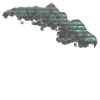

In [208]:
x.loc[(66, 181)]

In [ ]:
for i in x:
    try:
        if not x.is_valid:
            print(i)
    except:
        print(i)

Too few points in geometry component at or near point -34213.333100699805 76994.365408891361
Too few points in geometry component at or near point -34213.333100699805 76994.365408891361
Too few points in geometry component at or near point -107402.79533418639 -110133.97144869115
Too few points in geometry component at or near point -474721.96359735768 -287202.79398410325
Too few points in geometry component at or near point -289216.17363055289 -10605.43594103139
Too few points in geometry component at or near point -34213.333100699805 76994.365408891361
Too few points in geometry component at or near point -54734.250950006179 -213705.76180403051


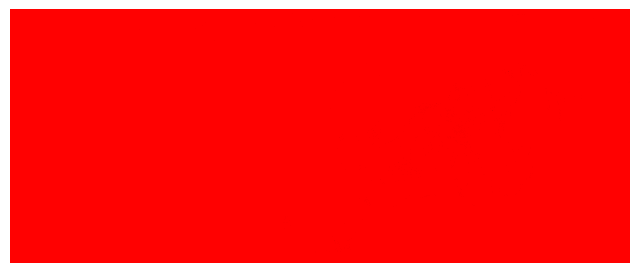

In [214]:
gplt.polyplot(
    x.simplify(2), 
    projection=proj, 
    linewidth=0, 
    facecolor='red', 
    alpha=0.3
)


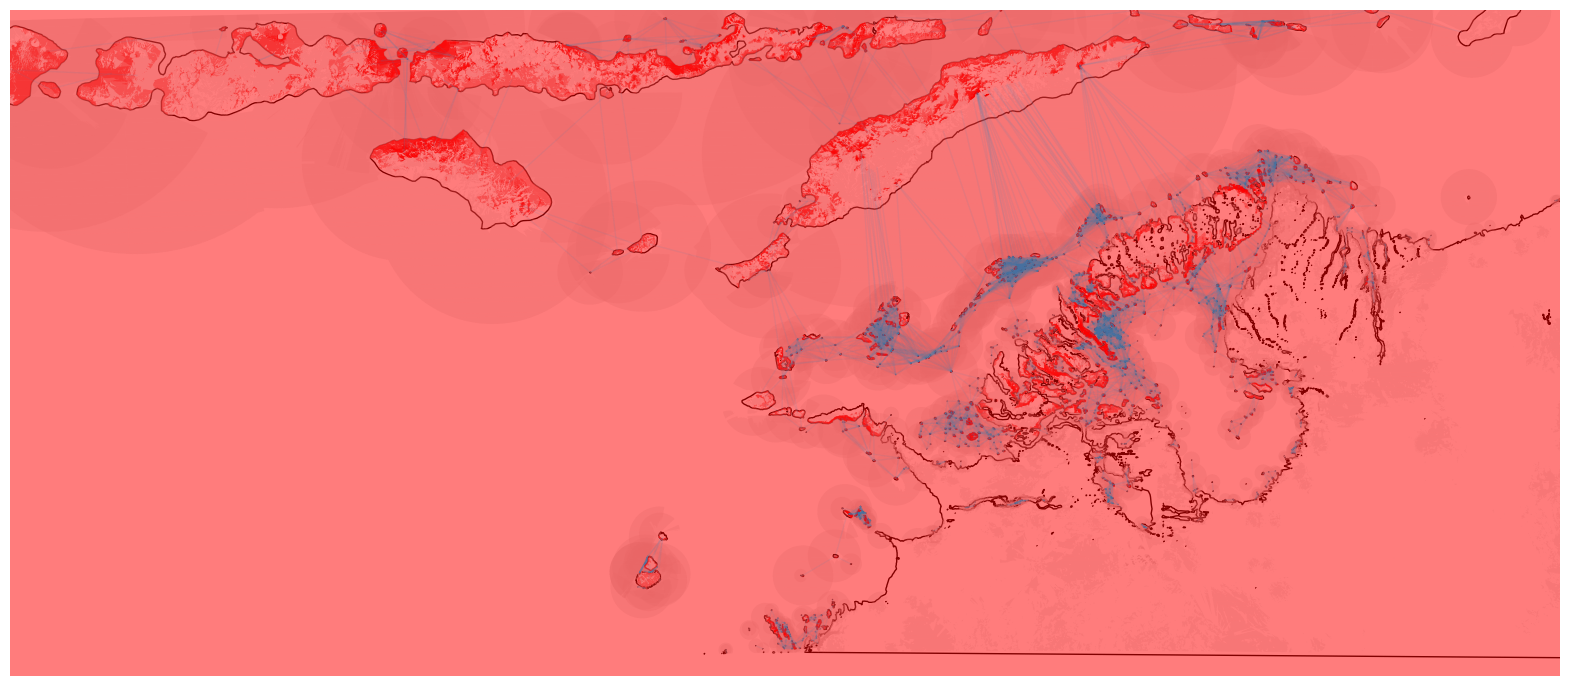

In [206]:
proj = gplt.crs.TransverseMercator()
ax = gplt.polyplot(
    islands, 
    projection=proj, 
    figsize=(20, 20), 
    color='darkgray'
)
gplt.polyplot(
    poly_viewsheds, 
    projection=proj, 
    ax=ax, 
    linewidth=0, 
    facecolor='lightgray', 
    alpha=0.3
)
gplt.polyplot(
    x, 
    projection=proj, 
    ax=ax, 
    linewidth=0, 
    facecolor='red', 
    alpha=0.3
)
gplt.sankey(
    paths, 
    start='geometry_ab', 
    end='geometry_ba', 
    ax=ax, 
    projection=proj, 
    alpha=0.05,
    rasterized=False
)


plt.savefig('interviz.pdf')
plt.show()

In [ ]:
plt.plot()

In [ ]:
x = gg[gg.apply(lambda x: not x.is_empty and x.area > 1e-9)]
xa = gpd.GeoDataFrame(x.centroid, geometry=0, crs=islands.crs)
xa.columns = ['geometry']
xa_tmp = xa.reset_index()
xa_tmp['idx'] = xa_tmp.apply(lambda y: (y.idx_a, y.idx_b), axis=1)
xa_tmp['idx_other'] = xa_tmp.apply(lambda y: (y.idx_b, y.idx_a), axis=1)
xa_tmp = xa_tmp.set_index('idx')
paths = xa_tmp.join(xa_tmp, on='idx_other', lsuffix='_ab', rsuffix='_ba')
paths = paths[paths.apply(lambda y: y.geometry_ab is not np.nan and y.geometry_ba is not np.nan, axis=1)]

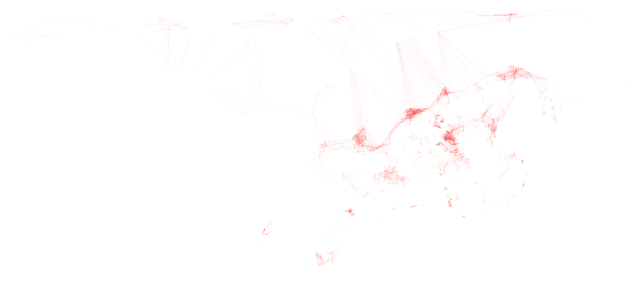

In [205]:
gplt.sankey(
    paths, 
    start='geometry_ab', 
    end='geometry_ba', 
#     ax=ax, 
    projection=proj, 
    alpha=0.01,
    color='red'
)

In [118]:
gg[gg.apply(lambda x: not x.is_empty)]

idx_a  idx_b
927    902      (POLYGON ((125.285235898502 -12.440893901035, ...
437    406      POLYGON ((126.507735898502 -11.03187986199528,...
43     3        POLYGON ((122.132735898502 -8.108393901034999,...
104    115      POLYGON ((128.3352358985021 -9.915893901034963...
1246   1247     (POLYGON ((123.3094054544428 -14.790893901035,...
124    110      (POLYGON ((129.2737866447615 -9.880893901035, ...
968    988      POLYGON ((125.4827358985023 -12.73589390103501...
678    667      POLYGON ((125.277735898502 -11.65359520212925,...
347    393      POLYGON ((128.102735898502 -11.000893901035, 1...
1032   1029     POLYGON ((124.6938314795568 -12.955893901035, ...
647    660      (POLYGON ((126.705235898502 -11.640893901035, ...
321    278      (POLYGON ((125.822735898502 -10.7096108872868,...
543    583      POLYGON ((126.950235898502 -11.50089390103473,...
967    891      POLYGON ((125.472735898502 -12.405893901035, 1...
898    938      POLYGON ((125.130235898502 -12.5356658874449, .

In [108]:
for x in gg:
    if x.is_empty:
        print(x)


POLYGON EMPTY
POLYGON EMPTY


In [153]:
rc = r_unique.copy()
rc['from'] = r_unique.centroid.loc[f]
rc['to'] = r_unique.centroid.loc[b].apply(lambda row: (row,))

In [152]:
rc = rc.to

In [140]:
rc.loc[b].head()

geometry
index_right index                                              
0           32     POINT (125.6042419059899 -8.216693859646917)
            59     POINT (125.0068434661167 -8.222921994796517)
            189     POINT (126.023752371104 -8.590301661496985)
1           28     POINT (128.9734510783919 -8.212909551607369)
            20     POINT (128.7399000631915 -8.178440180158013)

In [1]:
# ax = gplt.polyplot(islands, projection=gplt.crs.TransverseMercator(), figsize=(20, 20))
# gplt.polyplot(y, projection=gplt.crs.TransverseMercator(), ax=ax, linewidth=0, facecolor='lightgray', alpha=0.3)
gplt.sankey(start=rc['from'], end=rc['to'], projection=gplt.crs.TransverseMercator(), alpha=0.4)

NameError: name 'gplt' is not defined

FID
0       POINT (125.7619418607224 -8.022246080170657)
0       POINT (125.7619418607224 -8.022246080170657)
0       POINT (125.7619418607224 -8.022246080170657)
1       POINT (129.7381903495972 -8.029839325095688)
1       POINT (129.7381903495972 -8.029839325095688)
1       POINT (129.7381903495972 -8.029839325095688)
1       POINT (129.7381903495972 -8.029839325095688)
2        POINT (127.183450787513 -8.064602888323758)
2        POINT (127.183450787513 -8.064602888323758)
2        POINT (127.183450787513 -8.064602888323758)
2        POINT (127.183450787513 -8.064602888323758)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392

In [177]:
islands.iloc[0].geometry.centroid.y

-8.022246080170657

In [167]:
row[1]

1276

In [172]:
y.ix[row[1]]

geometry      (POLYGON ((123.570235898502 -14.920893901035, ...
FID_point                                                  1486
raster_val                                                    1
Name: 1276, dtype: object

In [166]:
row[1]
y.iloc[row[1]]
islands.iloc[row[0]].geometry

IndexError: single positional indexer is out-of-bounds

In [163]:
row

index            72
index_right    1276
Name: 1400, dtype: int64

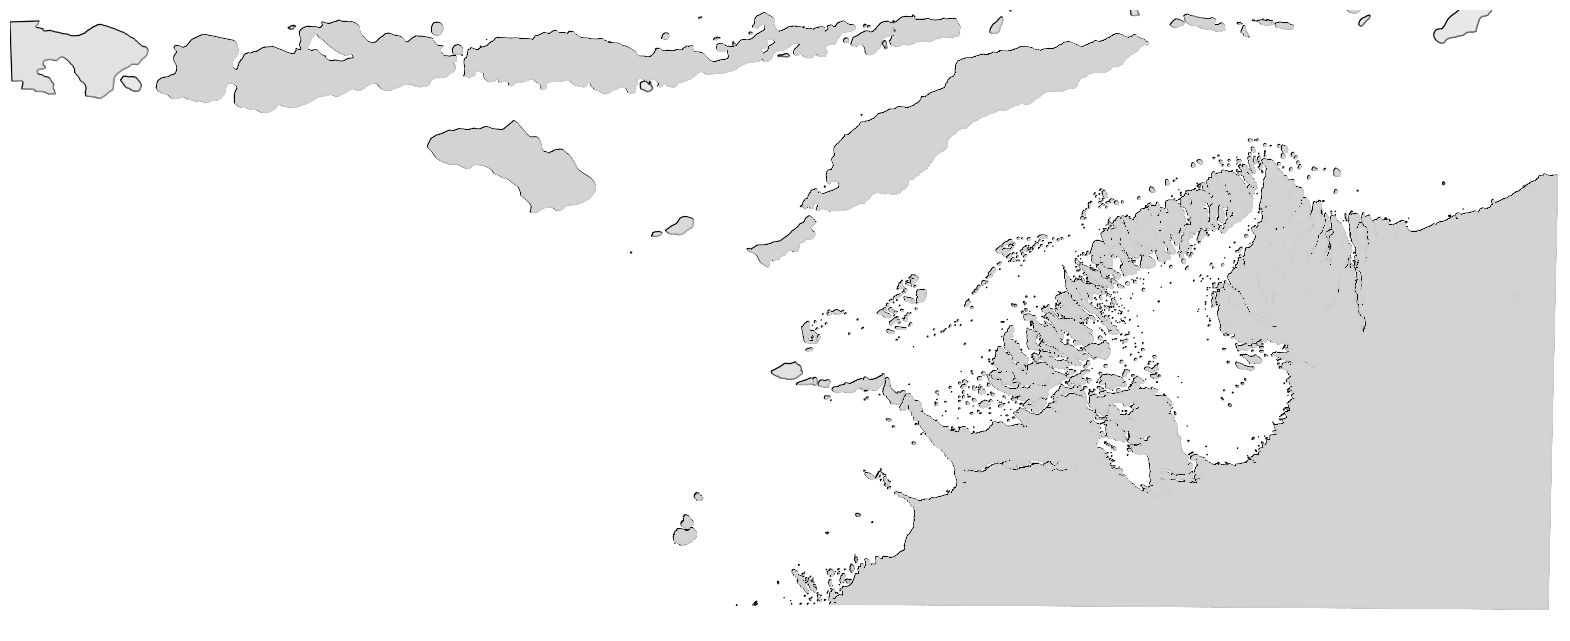

In [103]:
ax = gplt.polyplot(islands, projection=gplt.crs.TransverseMercator(), figsize=(20, 20))
gplt.polyplot(r_unique, projection=gplt.crs.TransverseMercator(), ax=ax, linewidth=0, facecolor='lightgray', alpha=0.3)

In [130]:
islands['geometry'] = islands.buffer(0)

In [143]:
islands.shape

(1277, 3)

In [144]:
y.shape

(1268, 3)

In [129]:
intersected = y.intersection(islands.buffer(0))

0       POLYGON ((125.760235898502 -8.039592896254529,...
1       (POLYGON ((129.760235898502 -8.043393901034998...
2       (POLYGON ((127.175235898502 -8.103393901035, 1...
3       POLYGON ((122.110235898502 -8.125045589614972,...
4       POLYGON ((124.6212182209325 -8.123393901034998...
5       POLYGON ((128.6827358985021 -8.15089390103492,...
6       POLYGON ((128.6827358985021 -8.15089390103492,...
7       POLYGON ((128.5627358985022 -8.160893901034967...
8       POLYGON ((128.7502358985022 -8.160893901034967...
9       (POLYGON ((128.5627358985023 -8.16089390103499...
10      (POLYGON ((128.7409435180143 -8.16089390103499...
11      (POLYGON ((128.7527358985021 -8.16089390103499...
12      (POLYGON ((128.5792836205527 -8.16089390103499...
13      POLYGON ((128.5845722986948 -8.165893901035, 1...
14      (POLYGON ((117.363935340719 -8.165893901035, 1...
15      POLYGON ((124.370235898502 -8.170893901034999,...
16      POLYGON ((128.3879314117754 -8.190893901034999...
17      (POLYG

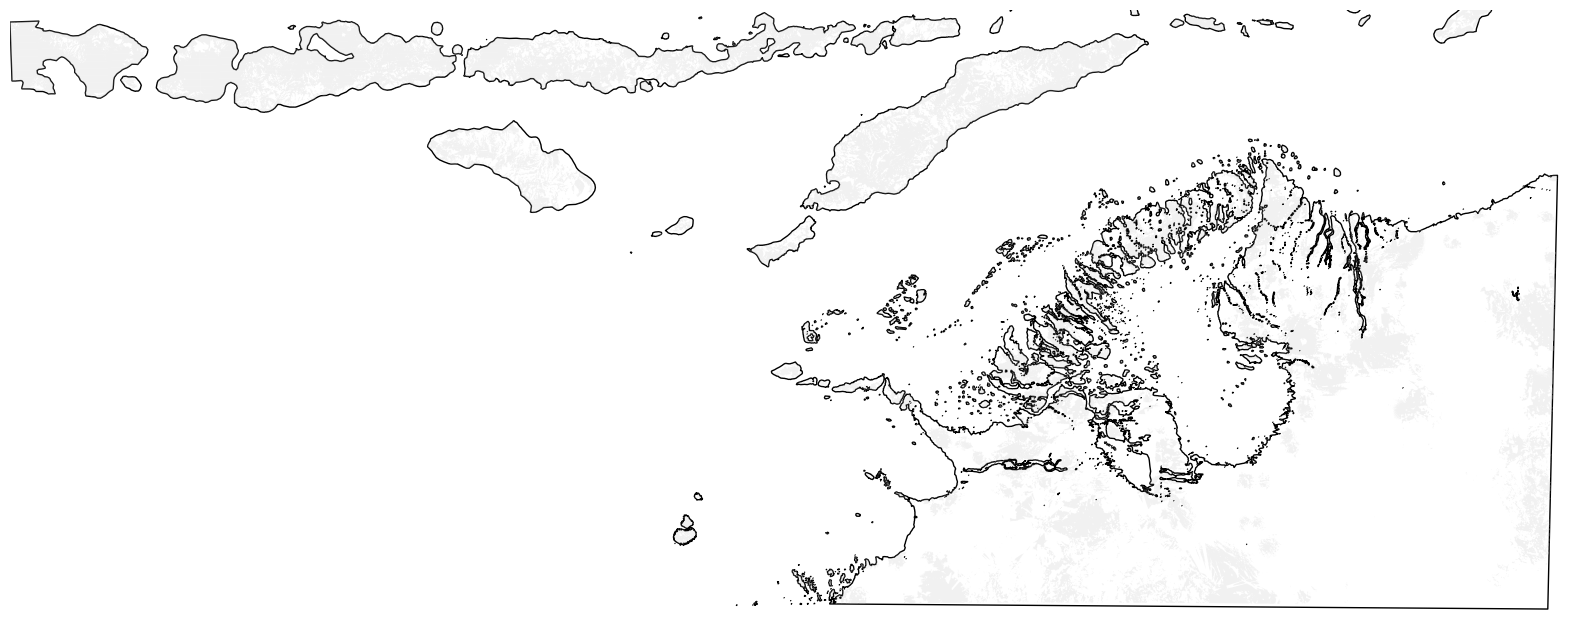

In [142]:
ax = gplt.polyplot(islands, projection=gplt.crs.TransverseMercator(), figsize=(20, 20))
gplt.polyplot(intersected[intersected.area > 0].buffer(0), projection=gplt.crs.TransverseMercator(), ax=ax, linewidth=0, facecolor='lightgray', alpha=0.3)